## Load necessary packages

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json
import json as pd

## Check GPU Access

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

True


## Load Data

In [3]:
import pandas as pd

file_path = "Data/PubMedQA_cleaned.json"
QA_data = pd.read_json(file_path)

In [6]:
data = QA_data.head(500) 

In [7]:
# Calculate class weights based on the training data
class_counts = data['gold_index'].value_counts().sort_index().values 
total_samples = len(data)
class_weights = torch.tensor([total_samples / count for count in class_counts], dtype=torch.float).to(device)

print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: [171  50 279]
Class weights: tensor([ 2.9240, 10.0000,  1.7921], device='cuda:0')


## Hugging Face Login

In [8]:
import os
from huggingface_hub import login

hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Teacher Model

In [9]:
# teacher_model_name = "Henrychur/MMed-Llama-3-8B" 
teacher_model_name = "microsoft/biogpt" 
# teacher_model_name = "stanford-crfm/BioMedLM"
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModelForCausalLM.from_pretrained(teacher_model_name)

In [10]:
# Assign eos_token as pad_token
teacher_tokenizer.pad_token = teacher_tokenizer.eos_token

In [11]:
# Add a classification head to the teacher model
class ClassificationHeadModel(nn.Module):
    def __init__(self, base_model, num_classes=3, class_weights=None):
        super(ClassificationHeadModel, self).__init__()
        self.base_model = base_model
        self.classification_head = nn.Linear(base_model.config.hidden_size, num_classes)  # Classification head
        self.class_weights = class_weights  # Store class weights

    def forward(self, input_ids, attention_mask, labels=None):
        # Get the hidden states from the base model
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]  # Use the last hidden layer

        # Take the hidden state of the first token ([CLS] or equivalent)
        cls_hidden_state = hidden_states[:, 0, :]  # Shape: (batch_size, hidden_size)

        # Pass through the classification head
        logits = self.classification_head(cls_hidden_state)  # Shape: (batch_size, num_classes)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)  # Use class weights for imbalanced data
            loss = loss_fn(logits, labels)

        return logits, loss


In [12]:
# Wrap the teacher model with the classification head
num_classes = 3
model = ClassificationHeadModel(teacher_model, num_classes=num_classes).to(device)

## Tokenize Data

In [13]:
# Prepare the dataset
class QADataset(Dataset):
    def __init__(self, tokenizer, data, max_length=512):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        input_text = f"Context: {row['context']} Question: {row['question']}"
        label = row['gold_index']  # The correct class index (0, 1, or 2)

        # Tokenize the input text
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


## Train/Test Split

In [14]:
# Split the dataset into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.3, random_state=401)

In [16]:
# Create DataLoaders
train_dataset = QADataset(teacher_tokenizer, train_data)
val_dataset = QADataset(teacher_tokenizer, val_data)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)


## Fine-tuning

In [14]:
from torch.cuda.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [18]:
# Fine-tune the model
optimizer = AdamW(model.parameters(), lr=5e-4)
num_epochs = 10

In [19]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# Early Stopping parameters
best_val_loss = float("inf")
patience = 5  # Number of epochs to wait before stopping
counter = 0

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits, loss = outputs  # Unpack the tuple

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits, loss = outputs  # Unpack the tuple

            val_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for additional metrics
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    accuracy = correct / total
    val_accuracies.append(accuracy)

    # Calculate additional metrics
    precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=0)

    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)

    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1 - Train Loss: 13.2783, Val Loss: 2.8988, Accuracy: 0.5667, Precision: 0.3211, Recall: 0.5667, F1-Score: 0.4099
Best model saved!
Epoch 2 - Train Loss: 3.6379, Val Loss: 1.3537, Accuracy: 0.5667, Precision: 0.3211, Recall: 0.5667, F1-Score: 0.4099
Best model saved!
Epoch 3 - Train Loss: 2.4526, Val Loss: 1.0374, Accuracy: 0.5667, Precision: 0.3211, Recall: 0.5667, F1-Score: 0.4099
Best model saved!
Epoch 4 - Train Loss: 1.3476, Val Loss: 1.0023, Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, F1-Score: 0.1667
Best model saved!
Epoch 5 - Train Loss: 1.4609, Val Loss: 1.4594, Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, F1-Score: 0.1667
Epoch 6 - Train Loss: 1.4910, Val Loss: 2.0674, Accuracy: 0.5667, Precision: 0.3211, Recall: 0.5667, F1-Score: 0.4099
Epoch 7 - Train Loss: 1.4405, Val Loss: 1.7493, Accuracy: 0.5667, Precision: 0.3211, Recall: 0.5667, F1-Score: 0.4099
Epoch 8 - Train Loss: 1.2486, Val Loss: 1.0560, Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, 

In [22]:
# Float16
# Enable mixed precision with GradScaler
scaler = GradScaler()

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}")):
        # Move inputs to GPU
        input_ids = batch["input_ids"].to(device)  # Keep as integers
        attention_mask = batch["attention_mask"].to(device).half()  # Convert to float16
        labels = batch["label"].to(device)  # Keep as integers

        # Forward pass with mixed precision
        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]
            
        # Check for NaN or inf in the loss
        if torch.isnan(loss) or torch.isinf(loss):
            print("Skipping batch due to NaN or inf in loss")
            optimizer.zero_grad()
            continue

        # Backward pass with scaled loss
        scaler.scale(loss).backward()

        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)  # Track training loss
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validating"):
            input_ids = batch["input_ids"].to(device)  # Keep as integers
            attention_mask = batch["attention_mask"].to(device).half()  # Convert to float16
            labels = batch["label"].to(device)  # Keep as integers

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs["loss"]
                logits = outputs["logits"]

            val_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_dataloader)
    accuracy = correct / total
    val_losses.append(avg_val_loss)  # Track validation loss
    val_accuracies.append(accuracy)  # Track validation accuracy
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f} - Accuracy: {accuracy:.4f}")

/tmp/ipykernel_62363/1996360984.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_62363/1996360984.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training Epoch 1:  17%|█▋        | 17/100 [00:04<00:22,  3.70it/s]


KeyboardInterrupt: 

In [28]:
from collections import Counter

# Check the distribution of predictions
predicted_classes = Counter(all_predictions)
print("Predicted class distribution:", predicted_classes)

Predicted class distribution: Counter({np.int64(0): 150})


## Plot

In [20]:
import matplotlib.pyplot as plt

In [21]:
epochs = list(range(1, len(val_losses) + 1))  # Epoch numbers

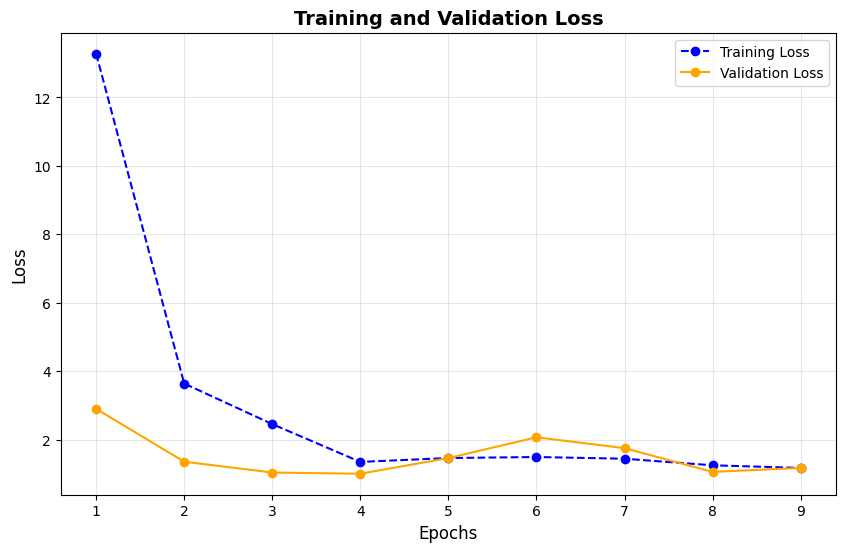

In [25]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker="o", linestyle="--", color="blue")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o", linestyle="-", color="orange")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

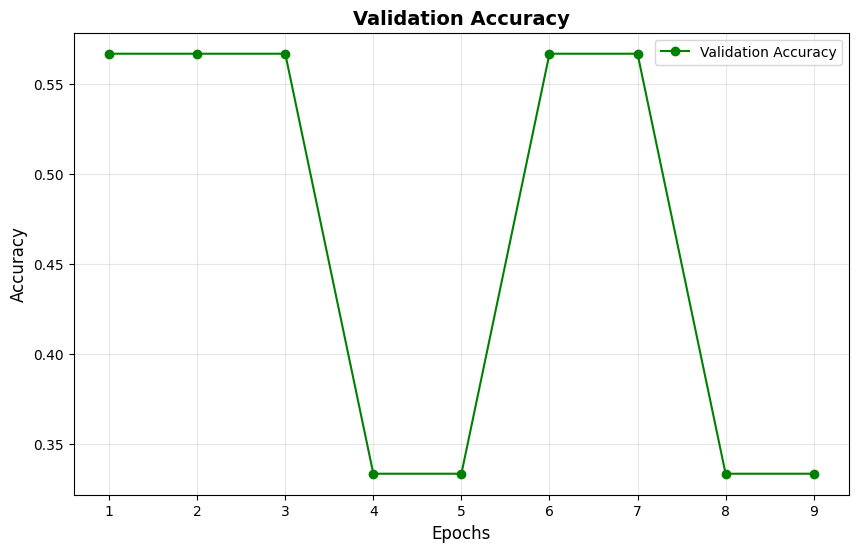

In [26]:
# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o", linestyle="-", color="green")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Validation Accuracy", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

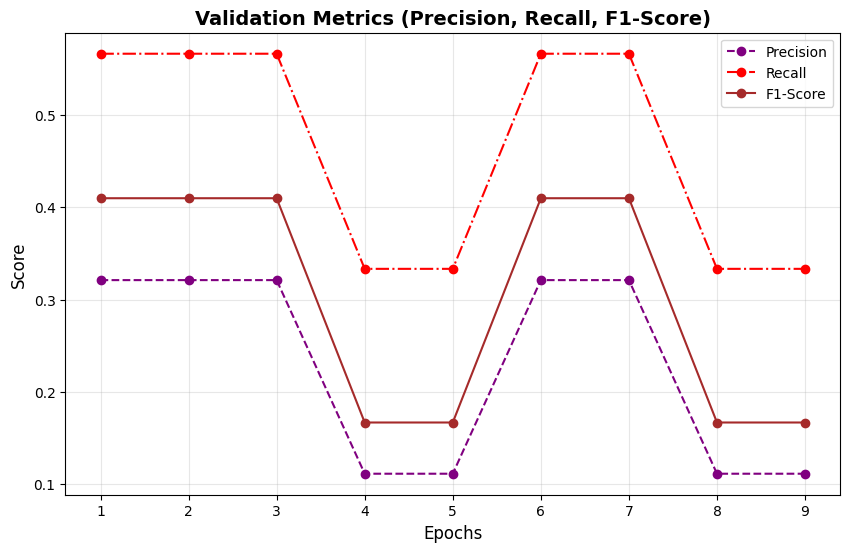

In [24]:
# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_precisions, label="Precision", marker="o", linestyle="--", color="purple")
plt.plot(epochs, val_recalls, label="Recall", marker="o", linestyle="-.", color="red")
plt.plot(epochs, val_f1_scores, label="F1-Score", marker="o", linestyle="-", color="brown")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Validation Metrics (Precision, Recall, F1-Score)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()